# Face Recognition Model

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers, optimizers, models

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [117]:
import zipfile
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/Gender Dataset.zip", 'r')
zip_ref.extractall("/content/drive/MyDrive/New Gender Dataset")
zip_ref.close()

In [118]:
train_data_path="/content/drive/MyDrive/New Gender Dataset/Training"
val_data_path="/content/drive/MyDrive/New Gender Dataset/Validation"

In [119]:
names=os.listdir(train_data_path)
names

['female', 'male']

In [120]:
count=0
for name in names:
    size=len(os.listdir(os.path.join(train_data_path, name)))
    count+=size
print("Total Training Images: ", count)

count=0
for name in names:
    size=len(os.listdir(os.path.join(val_data_path, name)))
    count+=size
print("Total Validation Images: ", count)

Total Training Images:  47009
Total Validation Images:  11649


# Data Pre Processing

# Using ImageDataGenerator to read images from directories

In [121]:
datagenerator=ImageDataGenerator(
                             rescale=1./255)

In [122]:
train_gen= datagenerator.flow_from_directory(
                                              train_data_path,
                                              batch_size=50,
                                              target_size=(96,96),
                                              class_mode='binary'
                                            )

Found 47009 images belonging to 2 classes.


In [123]:
val_gen= datagenerator.flow_from_directory(
                                              val_data_path,
                                              batch_size=35,
                                              target_size=(96,96),
                                              class_mode='binary'
                                            )

Found 11649 images belonging to 2 classes.


In [124]:
labels=train_gen.class_indices
labels

{'female': 0, 'male': 1}

In [125]:
pre_trained_model=InceptionV3(input_shape=(96,96,3),  include_top=False,  weights='imagenet')

In [126]:
for layer in pre_trained_model.layers:
  layer.trainable=False

In [127]:
pre_trained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_658 (Conv2D)            (None, 47, 47, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_658 (Batch  (None, 47, 47, 32)  96          ['conv2d_658[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_658 (Activation)    (None, 47, 47, 32)   0           ['batch_normalization_

In [128]:
last_layer=pre_trained_model.get_layer('mixed7')

print("Last layer Output Shape: ", last_layer.output_shape)

last_output= last_layer.output

Last layer Output Shape:  (None, 4, 4, 768)


# Creating Network Architecture

In [129]:
x=layers.Flatten()(last_output)
x=layers.Dense(128, activation='relu')(x)
x=layers.Dropout(0.4)(x)
x=layers.Dense(1, activation='sigmoid')(x)

model=models.Model(pre_trained_model.input, x)

In [130]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d_658 (Conv2D)            (None, 47, 47, 32)   864         ['input_8[0][0]']                
                                                                                                  
 batch_normalization_658 (Batch  (None, 47, 47, 32)  96          ['conv2d_658[0][0]']             
 Normalization)                                                                                   
                                                                                                  
 activation_658 (Activation)    (None, 47, 47, 32)   0           ['batch_normalization_658[0

In [131]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [132]:
class mycallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get("accuracy") is not None and logs.get('accuracy')>=0.96:
            print("\n Reached 96 accuracy so cancelling training")
            self.model.stop_training=True

callbacks=mycallback()

# Training

In [133]:
history=model.fit(train_gen, epochs=50, callbacks=[callbacks], validation_data=val_gen)

Epoch 1/50
941/941 [==============================] - 147s 151ms/step - loss: 0.2323 - accuracy: 0.9107 - val_loss: 0.1513 - val_accuracy: 0.9433
Epoch 2/50
941/941 [==============================] - 128s 136ms/step - loss: 0.1796 - accuracy: 0.9342 - val_loss: 0.1475 - val_accuracy: 0.9436
Epoch 3/50
941/941 [==============================] - 126s 134ms/step - loss: 0.1599 - accuracy: 0.9399 - val_loss: 0.1856 - val_accuracy: 0.9239
Epoch 4/50
941/941 [==============================] - 140s 149ms/step - loss: 0.1507 - accuracy: 0.9439 - val_loss: 0.1360 - val_accuracy: 0.9495
Epoch 5/50
941/941 [==============================] - 123s 130ms/step - loss: 0.1373 - accuracy: 0.9492 - val_loss: 0.1372 - val_accuracy: 0.9478
Epoch 6/50
941/941 [==============================] - 140s 149ms/step - loss: 0.1272 - accuracy: 0.9522 - val_loss: 0.1486 - val_accuracy: 0.9433
Epoch 7/50
941/941 [==============================] - 122s 130ms/step - loss: 0.1235 - accuracy: 0.9546 - val_loss: 0.1415 -

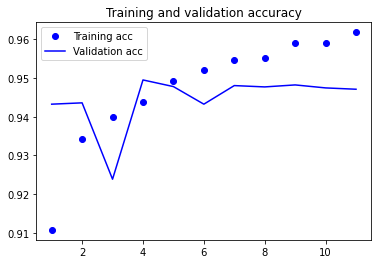

In [134]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

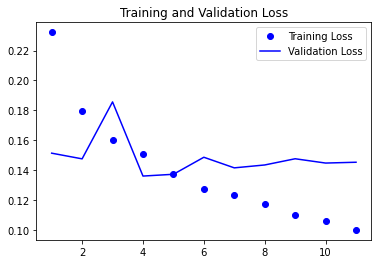

In [135]:
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs= range(1,len(loss)+1)
plt.plot(epochs, loss, 'bo', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss" )
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

In [141]:
model.save("/content/drive/MyDrive/New Gender_Recognition_Model_Org.h5")

In [137]:
test_data_path="/content/drive/MyDrive/New Gender Dataset/Validation"

In [138]:
test_generator=datagenerator.flow_from_directory(
                                            test_data_path,
                                            batch_size=2,
                                            target_size=(96,96),
                                            class_mode='binary'
                                            )

Found 11649 images belonging to 2 classes.


In [139]:
loss,acc= model.evaluate(test_generator)

5825/5825 [==============================] - 103s 18ms/step - loss: 0.1452 - accuracy: 0.9471


In [140]:
print("Test Data Loss: ",loss)
print("Test Data Accuracy: ",acc)

Test Data Loss:  0.14521880447864532
Test Data Accuracy:  0.947119951248169
